# Art Creation with Neural Style Transfer in TensorFlow

Neural Style Transfer merges two images, namely, a "content" image (C) and a "style" image (S), to create a "generated" image (G). The generated image G combines the "content" of the image C with the "style" of image S.  NST uses a previously trained convolutional network and builds upon it.

The model used in this notebook is VGG-19, a 19-layer version of the VGG network featured in the original NST paper https://arxiv.org/abs/1508.06576.  This model has already been trained on the very large ImageNet database, and thus has learned to recognize a variety of low and high level features.

The NST algorithm is built in three steps:

- Build the content cost function $J_{content}(C,G)$
- Build the style cost function $J_{style}(S,G)$
- Put it together to get $J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$. 

**Important:** The content image, style image and imagenet-vgg-verydeep-19.mat files (which can be found on Kaggle) - as well as a folder called 'output' - all need to be placed in the same location as this notebook. 

This notebook uses an image of St Pauls Cathedral, London, as the content image, and Vincent van Gogh's 'Starry Night' as the style image; if you decide to use different images they will need to be 400x300 in size to work 'as is'; if you use a different size image you will need to change the dimensions of the model to match those of the input.

## Import Modules

In [1]:
import os
import sys
import scipy.io
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import tensorflow as tf
import imageio

%matplotlib inline

## Helper Functions

In [2]:
class CONFIG:
    IMAGE_WIDTH = 400
    IMAGE_HEIGHT = 300
    COLOR_CHANNELS = 3
    NOISE_RATIO = 0.6
    MEANS = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3)) 
    VGG_MODEL = 'pretrained-model/imagenet-vgg-verydeep-19.mat' 
    STYLE_IMAGE = 'images/stone_style.jpg' # Style image to use.
    CONTENT_IMAGE = 'images/content300.jpg' # Content image to use.
    OUTPUT_DIR = 'output/'
    
def load_vgg_model(path):
    
    vgg = scipy.io.loadmat(path)

    vgg_layers = vgg['layers']
    
    def _weights(layer, expected_layer_name):

        wb = vgg_layers[0][layer][0][0][2]
        W = wb[0][0]
        b = wb[0][1]
        layer_name = vgg_layers[0][layer][0][0][0][0]
        assert layer_name == expected_layer_name
        return W, b

        return W, b

    def _relu(conv2d_layer):

        return tf.nn.relu(conv2d_layer)

    def _conv2d(prev_layer, layer, layer_name):

        W, b = _weights(layer, layer_name)
        W = tf.constant(W)
        b = tf.constant(np.reshape(b, (b.size)))
        return tf.nn.conv2d(prev_layer, filter=W, strides=[1, 1, 1, 1], padding='SAME') + b

    def _conv2d_relu(prev_layer, layer, layer_name):

        return _relu(_conv2d(prev_layer, layer, layer_name))

    def _avgpool(prev_layer):

        return tf.nn.avg_pool(prev_layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    # Construct the graph model
    graph = {}
    graph['input']   = tf.Variable(np.zeros((1, CONFIG.IMAGE_HEIGHT, CONFIG.IMAGE_WIDTH, CONFIG.COLOR_CHANNELS)), \
                                   dtype = 'float32')
    graph['conv1_1']  = _conv2d_relu(graph['input'], 0, 'conv1_1')
    graph['conv1_2']  = _conv2d_relu(graph['conv1_1'], 2, 'conv1_2')
    graph['avgpool1'] = _avgpool(graph['conv1_2'])
    graph['conv2_1']  = _conv2d_relu(graph['avgpool1'], 5, 'conv2_1')
    graph['conv2_2']  = _conv2d_relu(graph['conv2_1'], 7, 'conv2_2')
    graph['avgpool2'] = _avgpool(graph['conv2_2'])
    graph['conv3_1']  = _conv2d_relu(graph['avgpool2'], 10, 'conv3_1')
    graph['conv3_2']  = _conv2d_relu(graph['conv3_1'], 12, 'conv3_2')
    graph['conv3_3']  = _conv2d_relu(graph['conv3_2'], 14, 'conv3_3')
    graph['conv3_4']  = _conv2d_relu(graph['conv3_3'], 16, 'conv3_4')
    graph['avgpool3'] = _avgpool(graph['conv3_4'])
    graph['conv4_1']  = _conv2d_relu(graph['avgpool3'], 19, 'conv4_1')
    graph['conv4_2']  = _conv2d_relu(graph['conv4_1'], 21, 'conv4_2')
    graph['conv4_3']  = _conv2d_relu(graph['conv4_2'], 23, 'conv4_3')
    graph['conv4_4']  = _conv2d_relu(graph['conv4_3'], 25, 'conv4_4')
    graph['avgpool4'] = _avgpool(graph['conv4_4'])
    graph['conv5_1']  = _conv2d_relu(graph['avgpool4'], 28, 'conv5_1')
    graph['conv5_2']  = _conv2d_relu(graph['conv5_1'], 30, 'conv5_2')
    graph['conv5_3']  = _conv2d_relu(graph['conv5_2'], 32, 'conv5_3')
    graph['conv5_4']  = _conv2d_relu(graph['conv5_3'], 34, 'conv5_4')
    graph['avgpool5'] = _avgpool(graph['conv5_4'])
    
    return graph

    """
    Configuration of the VGG model:
        0 is conv1_1 (3, 3, 3, 64)
        1 is relu
        2 is conv1_2 (3, 3, 64, 64)
        3 is relu    
        4 is maxpool
        5 is conv2_1 (3, 3, 64, 128)
        6 is relu
        7 is conv2_2 (3, 3, 128, 128)
        8 is relu
        9 is maxpool
        10 is conv3_1 (3, 3, 128, 256)
        11 is relu
        12 is conv3_2 (3, 3, 256, 256)
        13 is relu
        14 is conv3_3 (3, 3, 256, 256)
        15 is relu
        16 is conv3_4 (3, 3, 256, 256)
        17 is relu
        18 is maxpool
        19 is conv4_1 (3, 3, 256, 512)
        20 is relu
        21 is conv4_2 (3, 3, 512, 512)
        22 is relu
        23 is conv4_3 (3, 3, 512, 512)
        24 is relu
        25 is conv4_4 (3, 3, 512, 512)
        26 is relu
        27 is maxpool
        28 is conv5_1 (3, 3, 512, 512)
        29 is relu
        30 is conv5_2 (3, 3, 512, 512)
        31 is relu
        32 is conv5_3 (3, 3, 512, 512)
        33 is relu
        34 is conv5_4 (3, 3, 512, 512)
        35 is relu
        36 is maxpool
        37 is fullyconnected (7, 7, 512, 4096)
        38 is relu
        39 is fullyconnected (1, 1, 4096, 4096)
        40 is relu
        41 is fullyconnected (1, 1, 4096, 1000)
        42 is softmax
    """

def generate_noise_image(content_image, noise_ratio = CONFIG.NOISE_RATIO):
    
    # Generate a random noise_image
    noise_image = np.random.uniform(-20, 20, (1, CONFIG.IMAGE_HEIGHT, CONFIG.IMAGE_WIDTH, \
                                              CONFIG.COLOR_CHANNELS)).astype('float32')

    # Set the input_image to be a weighted average of content_image and noise_image
    input_image = noise_image * noise_ratio + content_image * (1 - noise_ratio)
    
    return input_image


def reshape_and_normalize_image(image):

    # Reshape image to mach expected input of model
    image = np.reshape(image, ((1,) + image.shape))
    
    # Substract the mean to match the expected input of model
    image = image - CONFIG.MEANS
    
    return image


def save_image(path, image):
    
    # Un-normalize image
    image = image + CONFIG.MEANS
    
    # Clip and save image
    image = np.clip(image[0], 0, 255).astype('uint8')
    imageio.imwrite(path, image)

## Load the Model

In [3]:
# Load a python dictionary of the VGG-19 model
model = load_vgg_model("imagenet-vgg-verydeep-19.mat")
print(model)

{'input': <tf.Variable 'Variable:0' shape=(1, 300, 400, 3) dtype=float32_ref>, 'conv1_1': <tf.Tensor 'Relu:0' shape=(1, 300, 400, 64) dtype=float32>, 'conv1_2': <tf.Tensor 'Relu_1:0' shape=(1, 300, 400, 64) dtype=float32>, 'avgpool1': <tf.Tensor 'AvgPool:0' shape=(1, 150, 200, 64) dtype=float32>, 'conv2_1': <tf.Tensor 'Relu_2:0' shape=(1, 150, 200, 128) dtype=float32>, 'conv2_2': <tf.Tensor 'Relu_3:0' shape=(1, 150, 200, 128) dtype=float32>, 'avgpool2': <tf.Tensor 'AvgPool_1:0' shape=(1, 75, 100, 128) dtype=float32>, 'conv3_1': <tf.Tensor 'Relu_4:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_2': <tf.Tensor 'Relu_5:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_3': <tf.Tensor 'Relu_6:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_4': <tf.Tensor 'Relu_7:0' shape=(1, 75, 100, 256) dtype=float32>, 'avgpool3': <tf.Tensor 'AvgPool_2:0' shape=(1, 38, 50, 256) dtype=float32>, 'conv4_1': <tf.Tensor 'Relu_8:0' shape=(1, 38, 50, 512) dtype=float32>, 'conv4_2': <tf.Tensor 'Relu_9:0' shap

## Content Image (C) and Content Cost

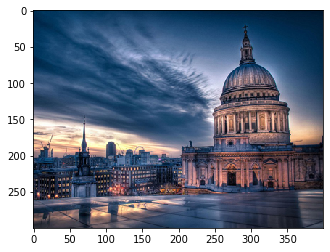

In [4]:
content_image = imageio.imread("stpauls.jpg")
imshow(content_image)


We would like the "generated" image G to have similar content as the input image C. In practice, the most visually pleasing results are obtained by choosing a layer in the middle of the network - neither too shallow nor too deep - to represent the content of an image.

Now, set the image C as the input to the pretrained VGG network, and run forward propagation. Let $a^{(C)}$ be the hidden layer activations in the chosen layer. This will be a $n_H \times n_W \times n_C$ tensor. Repeat this process with the image G: Set G as the input, and run forward progation. Let $a^{(G)}$ be the corresponding hidden layer activation. The content cost function is defined as:

$$J_{content}(C,G) =  \frac{1}{4 \times n_H \times n_W \times n_C}\sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2$$

For clarity, note that $a^{(C)}$ and $a^{(G)}$ are the volumes corresponding to a hidden layer's activations.

In [5]:
def compute_content_cost(a_C, a_G):
    
    # Retrieve dimensions from a_G
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape a_C and a_G
    a_C_unrolled = tf.transpose(tf.reshape(a_C, [-1]))
    a_G_unrolled = tf.transpose(tf.reshape(a_G, [-1]))
    
    # compute cost
    J_content = tf.reduce_sum((a_C_unrolled - a_G_unrolled)**2) / (4 * n_H * n_W * n_C)
    
    return J_content
    
    """
    Computes the content cost
    
    Arguments:
    a_C = tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G = tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content = scalar 
    """

In [6]:
tf.reset_default_graph()

with tf.Session() as test:
    a_C = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_content = compute_content_cost(a_C, a_G)
    print("J_content = " + str(J_content.eval()))

J_content = 8.635107


## Style Image (S) and Style Cost

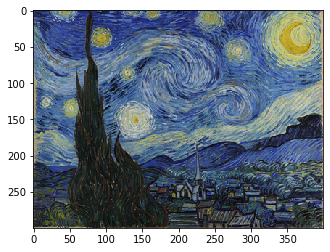

In [7]:
style_image = imageio.imread("starry.jpg")
imshow(style_image)

### Style (Gram) Matrix

In linear algebra, the Gram matrix G of a set of vectors $(v_{1},\dots ,v_{n})$ is the matrix of dot products, whose entries are ${\displaystyle G_{ij} = v_{i}^T v_{j} = np.dot(v_{i}, v_{j})  }$. In other words, $G_{ij}$ compares how similar $v_i$ is to $v_j$: If they are highly similar, you would expect them to have a large dot product, and thus for $G_{ij}$ to be large. 

Note that there is an unfortunate collision in the variable names used here. Following common terminology used in the literature, $G$ is used to denote the Style matrix (or Gram matrix) as well as to denote the generated image $G$. The $G$ being referred to should always be clear from the context.

In NST, the Style matrix can be computed by multiplying the unrolled filter matrix with its transpose.  The result is a matrix of dimension $(n_C,n_C)$ where $n_C$ is the number of filters. The value $G_{ij}$ measures how similar the activations of filter $i$ are to the activations of filter $j$. 

One important part of the gram matrix is that the diagonal elements such as $G_{ii}$ also measures how active filter $i$ is. For example, suppose filter $i$ is detecting vertical textures in the image. Then $G_{ii}$ measures how common  vertical textures are in the image as a whole: If $G_{ii}$ is large, this means that the image has a lot of vertical texture. 

By capturing the prevalence of different types of features ($G_{ii}$), as well as how much different features occur together ($G_{ij}$), the Style matrix $G$ measures the style of an image. 


In [8]:
def gram_matrix(A):
    
    GA = tf.matmul(A, tf.transpose(A)) 

    return GA

    """
    Argument:
    A = matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA = Gram matrix of A; shape = (n_C, n_C)
    """

In [9]:
tf.reset_default_graph()

with tf.Session() as test:
    A = tf.random_normal([3, 2*1], mean=1, stddev=4)
    GA = gram_matrix(A)
    
    print("GA = " + str(GA.eval()))

GA = [[10.337898  30.53655    6.0616026]
 [30.53655   92.28407   20.482164 ]
 [ 6.0616026 20.482164   6.741417 ]]


### Style Cost

The distance between the Gram matrix of the "style" image S and that of the "generated" image G needs to be minimised; the style cost for a single hidden layer $a^{[l]}$ is defined as:

$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{ij} - G^{(G)}_{ij})^2 $$

where $G^{(S)}$ and $G^{(G)}$ are respectively the Gram matrices of the "style" image and the "generated" image, computed using the hidden layer activations for a particular hidden layer in the network.  

In [10]:
def compute_layer_style_cost(a_S, a_G):
    
    # Retrieve dimensions from a_G 
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape the images to have them of shape (n_H*n_W, n_C)
    a_S = tf.reshape(a_S, [n_H*n_W, n_C])
    a_G = tf.reshape(a_G, [n_H*n_W, n_C])

    # Computing gram_matrices for both images S and G
    GS = gram_matrix(tf.transpose(a_S))
    GG = gram_matrix(tf.transpose(a_G))

    # Compute loss
    J_style_layer = tf.reduce_sum((GS - GG)**2) / (4 * n_C**2 * (n_W * n_H)**2)
    
    return J_style_layer

    """
    Arguments:
    a_S = tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G = tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer = tensor representing a scalar value
    """

In [11]:
tf.reset_default_graph()

with tf.Session() as test:
    a_S = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_style_layer = compute_layer_style_cost(a_S, a_G)
    
    print("J_style_layer = " + str(J_style_layer.eval()))

J_style_layer = 31.039927


### Style Weights

In [12]:
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

The style costs for different layers are merged as follows:

$$J_{style}(S,G) = \sum_{l} \lambda^{[l]} J^{[l]}_{style}(S,G)$$

where the values for $\lambda^{[l]}$ are given in `STYLE_LAYERS`. 


The `compute_style_cost(...)` function calls the `compute_layer_style_cost(...)` function several times, and weights their results using the values in `STYLE_LAYERS`.


In [13]:
def compute_style_cost(model, STYLE_LAYERS):
    
    # initialize overall style cost
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:

        # Select the output tensor of the currently selected layer
        out = model[layer_name]

        # Set a_S to be the hidden layer activation from the layer selected
        a_S = sess.run(out)

        # Set a_G to be the hidden layer activation from same layer
        a_G = out
        
        # Compute style_cost for current layer
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        # Add coeff * J_style_layer of this layer to overall style cost
        J_style += coeff * J_style_layer

    return J_style

    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    model = our tensorflow model
    STYLE_LAYERS = A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style = tensor representing a scalar value
    """

## Total Cost

The formula for minimising both the style and content costs is: 

$$J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$$

In [14]:
def total_cost(J_content, J_style, alpha = 10, beta = 40):

    J = alpha * J_content + beta * J_style

    return J

    """
    Computes total cost function
    
    Arguments:
    J_content = content cost 
    J_style = style cost
    alpha = hyperparameter weighting the importance of the content cost
    beta = hyperparameter weighting the importance of the style cost
    
    Returns:
    J = total cost
    """

In [15]:
tf.reset_default_graph()

with tf.Session() as test:
    J_content = np.random.randn()    
    J_style = np.random.randn()
    J = total_cost(J_content, J_style)
    print("J = " + str(J))

J = 18.861320359751627


## Solving the Optimization Problem

1. Create an Interactive Session
2. Load the content image 
3. Load the style image
4. Randomly initialize the image to be generated 
5. Load the model
7. Build the TensorFlow graph:
    - Run the content image through the model and compute the content cost
    - Run the style image through the model and compute the style cost
    - Compute the total cost
    - Define the optimizer and the learning rate
8. Initialize the TensorFlow graph and run it for a large number of iterations, updating the generated image at every step.

In [16]:
# Reset the graph
tf.reset_default_graph()

# Start interactive session
sess = tf.InteractiveSession()

Load, reshape and normalize the "content" image:

In [17]:
content_image = imageio.imread("stpauls.jpg")
content_image = reshape_and_normalize_image(content_image)

Load, reshape and normalize the "style" image:

In [18]:
style_image = imageio.imread("starry.jpg")
style_image = reshape_and_normalize_image(style_image)

Initialize the "generated" image as a noisy image created from the content_image. By initializing the pixels of the generated image to be mostly noise but still slightly correlated with the content image, this will help the content of the "generated" image more rapidly match the content of the "content" image.

W0711 15:51:38.999215 13472 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


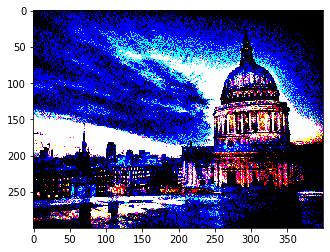

In [19]:
# Generate noisy image
generated_image = generate_noise_image(content_image)
imshow(generated_image[0])

Load model.

In [20]:
model = load_vgg_model("imagenet-vgg-verydeep-19.mat")

Assign `a_C` and `a_G` to be the appropriate hidden layer activations. We will use layer `conv4_2` to compute the content cost. The code below does the following:

1. Assign the content image to be the input to the VGG model.
2. Set a_C to be the tensor giving the hidden layer activation for layer "conv4_2".
3. Set a_G to be the tensor giving the hidden layer activation for the same layer. 
4. Compute the content cost using a_C and a_G.

In [21]:
# Assign content image to be the input of model
sess.run(model['input'].assign(content_image))

# Select output tensor of layer conv4_2
out = model['conv4_2']

# Set a_C to be the hidden layer activation from the layer selected
a_C = sess.run(out)

# Set a_G to be the hidden layer activation from same layer
a_G = out

# Compute content cost
J_content = compute_content_cost(a_C, a_G)

In [22]:
# Assign the input of the model to be the "style" image 
sess.run(model['input'].assign(style_image))

# Compute style cost
J_style = compute_style_cost(model, STYLE_LAYERS)

In [23]:
# Compute total cost
J = total_cost(J_content, J_style,  alpha = 10, beta = 40)

In [24]:
# Define optimizer
optimizer = tf.train.AdamOptimizer(2.0)

# Define train_step
train_step = optimizer.minimize(J)

W0711 15:52:04.421182 13472 deprecation.py:323] From C:\Users\rober\.conda\envs\tensorflow\lib\site-packages\tensorflow\python\ops\math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Initialise the variables of the tensorflow graph, assign the input image (initial generated image) as the input of the model and run the train_step for a large number of steps.

In [25]:
def model_nn(sess, input_image, num_iterations = 2000):
    
    # Initialize global variables
    sess.run(tf.global_variables_initializer())
    
    # Run the noisy input image (initial generated image) through the model
    sess.run(model['input'].assign(input_image))
    
    for i in range(num_iterations):
    
        # Run the session on the train_step to minimize the total cost
        _ = sess.run(train_step)
        
        # Compute the generated image
        generated_image = sess.run(model['input'])

        # Print every 20 iterations
        if i%20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            
            # save current generated image in the "/output" directory
            save_image("output/" + str(i) + ".png", generated_image)
    
    # save last generated image
    save_image('output/generated_image.jpg', generated_image)
    
    return generated_image

Run model.

In [26]:
model_nn(sess, generated_image)

Iteration 0 :
total cost = 3764078600.0
content cost = 11008.094
style cost = 94099220.0
Iteration 20 :
total cost = 324903840.0
content cost = 17294.494
style cost = 8118272.0
Iteration 40 :
total cost = 131454360.0
content cost = 18424.322
style cost = 3281753.0
Iteration 60 :
total cost = 82101980.0
content cost = 19045.22
style cost = 2047788.1
Iteration 80 :
total cost = 59388956.0
content cost = 19553.49
style cost = 1479835.5
Iteration 100 :
total cost = 46288708.0
content cost = 19915.707
style cost = 1152238.8
Iteration 120 :
total cost = 37763824.0
content cost = 20210.01
style cost = 939043.1
Iteration 140 :
total cost = 31825228.0
content cost = 20458.535
style cost = 790516.06
Iteration 160 :
total cost = 27407140.0
content cost = 20673.604
style cost = 680010.1
Iteration 180 :
total cost = 24010664.0
content cost = 20860.844
style cost = 595051.4
Iteration 200 :
total cost = 21326900.0
content cost = 21027.639
style cost = 527915.6
Iteration 220 :
total cost = 19145190.0


Iteration 1900 :
total cost = 1842691.2
content cost = 24291.006
style cost = 39994.53
Iteration 1920 :
total cost = 1816003.0
content cost = 24300.072
style cost = 39325.055
Iteration 1940 :
total cost = 3003094.8
content cost = 24220.703
style cost = 69022.195
Iteration 1960 :
total cost = 1850494.4
content cost = 24297.389
style cost = 40188.01
Iteration 1980 :
total cost = 1781535.9
content cost = 24321.09
style cost = 38458.125


array([[[[-21.49563   ,   8.906464  , -21.347366  ],
         [ -0.09313276,  17.09912   ,  -5.90941   ],
         [-33.401722  ,  27.060078  ,  21.140688  ],
         ...,
         [-57.95553   , -11.364528  ,  13.790232  ],
         [-45.954662  ,  28.576345  ,  14.703019  ],
         [-21.138575  ,  58.848602  ,  22.358622  ]],

        [[-37.39619   ,  -1.3781742 , -44.137806  ],
         [ 30.73489   ,  12.531907  , -27.36952   ],
         [-26.722971  , -15.643658  ,  21.932152  ],
         ...,
         [-57.355312  ,   4.8341746 ,  36.12507   ],
         [-34.365948  ,   7.563781  ,  31.542252  ],
         [-25.7647    ,  24.484385  ,  59.302353  ]],

        [[ -2.7361443 ,  62.53593   , -41.331493  ],
         [-31.36016   ,  16.855072  , -14.55824   ],
         [ -8.394074  ,  -6.365019  ,   7.490235  ],
         ...,
         [-83.5322    ,  -4.3059735 , -48.458786  ],
         [-18.049576  ,  15.484695  , -23.917559  ],
         [  5.555848  ,  10.082094  ,  25.99285   ]],

Display generated image.

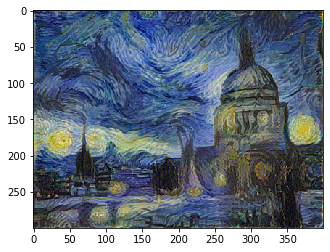

In [29]:
final_generated_image = imageio.imread("output/generated_image.jpg")
imshow(final_generated_image)